## Simple Diffusion Model -- the foundation

In this notebook, we are going to build up from scratch the simplest diffusion model possible. We are also going to use a very basic `UNET` for our setup. 

This notebook is predominantly inspired from these two amazing resources. 
1. [HuggingFace diffusion model from scratch notebook](https://github.com/huggingface/diffusion-models-class)
2. [Amazing explanatory video by Johno](https://youtu.be/09o5cv6u76c?si=BD8wrXTvREotIyt0)

To be honest, if you are here in this notebook, you might also have been very scared about the huge maths burden Diffusion Model brings. Don't worry, I also faced the same maths burden and to be honest I am still scared. What helped was to understand the concept from a computer scientist perspective. This is where this notebook comes into picture. In this notebook I will hold your hand, and we are going to understand diffusion model. No extravagant stuff, just basic diffusion model.

If you are sticking with me on this notebook, then let me remind you that we will slowly and steadily keep on building bigger and better models deriving everything we learn from this notebook.

So, without further adieu let's get this party started.

In [1]:
## Import very basic libraries ##

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST 
from torch.utils.data import DataLoader

from torchvision.transforms import transforms

from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Before we dive into everything, I am going to setup some utility functions. This will be very helpful to us in later cases.

#### Step 0 : Utility Functions

In [2]:
## We are going to build a utility function which displays a batch of images ##

def visualize_image_batch(img_batch : torch.tensor, nrow : int = None):
    """Visualizes a batch of images as a grid.
    
    Parameters
    ----------
    img_batch : torch.tensor
        A batch of images to be visualized.
        Shape = N,C,H,W
        
    nrow : int
        Number of images in a row.
        [Default : None]
    """
    
    if nrow is None:
        ## Setting the number of rows to sqrt of the number of elements in batch ##
        nrow = int(np.ceil(np.sqrt(img_batch.shape[0])))
    
    plt.imshow(make_grid(img_batch, nrow=nrow, normalize=True).permute(1,2,0).cpu().numpy(), cmap='gray')
    
    plt.axis("off")
    
    plt.show()

Now, the previous utility function can be a bit daunting, so let's explain it too and then move ahead. 

What the previous function does is take an `img_batch`. It is of shape (N,C,H,W) where N is the number of images in the batch, C is the number of channels, H and W are the heights and widths of the corresponding batch of images.

The above utility function uses the native `make_grid` function of the `torchvision.utils` package to create the grid of images. The `make_grid` function takes the `img_batch` as a first parameter. One of the other major parameters of the `make_grid` function is the `nrow` parameter which sets the number of images in a row in the grid. Typically it can be given as a parameter to our utility function. If it is not given I enforce the grid to be a square grid with equal number of images in rows and columns. Hence I took the square root of the number of images in the batch. Thats what the `nrow` variable holds and is passed to the `make_grid`. The `make_grid` function outputs a `torch.tensor` which consists of the required image grid as a whole and has the shape (C,H',W') where C is the number of channels, H' and W' are a generic height and width of the entire grid. 

Now we have the grid of images, and the only thing to do is view the images. You could think okay we can use `matplotlib.pyplot.imshow` and put this grid inside it and it would easily show the images. Well you are correct but not entirely. The thing is `matplotlib.pyplot.imshow` can only view images which of shape (H,W,C). But our grid tensor is of shape (C,H',W'). So we must change the orientation of the shape to correctly visualize it. Hence we use the `.permute(1,2,0)` function on the grid to make the correct orientation of the dimensions. Additionally I also do 2 things. I do a `.cpu()` and a `.numpy()`. I do this because `imshow()` doesn't work have any `cuda()` properties and works only on `cpu()`. Hence I enforce `cpu()` to really avoid any future errors. Also `imshow()` doesn't display tensors, hence I convert it to `numpy.ndarray` using `.numpy()`. And that's it.

Again do let me know if there are any issues on this utility function.

Now we move on to the major concepts necessary for understanding diffusion models.

#### Step 1 : Setting the dataset and the dataloader

To illustrate our very basic diffusion model we are going to use "the" most basic dataset in computer vision -- MNIST. So, we are just going to first load it. It is available in the `torchvision` library and is very easy for us to use. This is very basic and I hope it is not so difficult. If it is do let me know in the issues section. 

In [3]:
## Setting a really necessary augmentation ##

augmentation = transforms.Compose([
    transforms.ToTensor(),
])

## Loading the mnist dataset ##
## We are just going to use the training set ##
dataset = MNIST(root='data', train=True, download=True, transform=augmentation)

print(f'Yay! MNIST dataset is loaded!')

Yay! MNIST dataset is loaded!


*Side Note*: If you are running the above cell for the first time, there will be additional things which will be written in the output deck apart from 'Yay! MNIST dataset is loaded!'.

Perfect now we have our dataset, we will also setup our dataloader.

Dataloader is instantiated and has 3750 mini-batches in total!
Visualizing a batch...


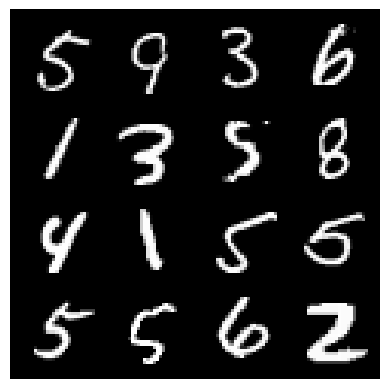

In [4]:
## Setting dataloader ##

dl = DataLoader(dataset, batch_size=16, shuffle=True)

print(f'Dataloader is instantiated and has {len(dl)} mini-batches in total!')

print(f'Visualizing a batch...')

for imgs, labels in dl:
    
    visualize_image_batch(imgs)
    
    break

Perfect. Now we have our basic dataloader ready. Now we are almost ready to "drum roll please" dive into Diffusion Models.

#### Step 2 : Hello Simple Diffusion

A typical diffusion model has two basic steps.

1. **Forward Step** : Progressively add noise to input image.
2. **Backward Step** : Progressively reduce noise from a gaussian noise to get the original image.

For this notebook we are not going to understand any mathematical formula, but rather this simple notion that diffusion model consists of two steps - forward and reverse. In forward step we add noise and in backward step we remove the noise. This is what is depicted in the figure below. Again, no formulas just basic understanding.

![diffusion_steps](diffusion_steps.png)

Now we know what a basic diffusion model is. We add certain amount of noise to an image and we remove it. This is diffusion model. But you might be wondering, well this is pretty simple ain't it?

Well to be honest, it does look really simple. One can easily add a certain amount of noise to an image and it would be a noisy image considered in the forward process. That is very direct. So why not build that up and then we can talk more about the reverse process. 

#### Step 2a : Forward Process

So we are going to build the forward process of the diffusion model now. What I would suggest is take a pause here and think what would the forward process need.

If you have paused and given a thought lets discuss this step by step.

Well the forward process will obviously need the original image and it would need something else. What would it be? Well it would need the amount of noise to add to the image. So basically the forward process would need two things -- the images and the amount of noises to add. 

Okay so now have the amount of noise to add to the image and the original images itself. Then what to do?

Well we can generate a noise using the very easy `torch.rand` function which generates random values between `[0,1)`. This will be our noise. Now we have our noise too. So how to add this noise to the oirginal image?

Well think of it in this way, when the amount is minimum (say, `0`) we have the original image as shown in the above diagram and when the amount is maximum (say, `1`) we have the noise. So, what we can do is do an weighted sum of the image and the noise. The weight is given by our `amount` parameter and can be formulated as follows.

`noisy_images = (1 - amount) * images + (amount) * noise`

This clearly shows that when amount is suppose 0 (the minimum) then only the 1st part of the equation is left whereas if the amount is 1 (the maximum) then the 2nd part of the equation is left. Amazing right?

I hope this is nicely clarified and we can code up the forward process next. See we don't need those fancy mathematical formulas to understand this concept. Again I want to remind you if you feel that the explanation is not good please write me in the issues.

In [5]:
## Implementing a forward process of the diffusion model ##

def forward_process(images : torch.tensor, amount : torch.tensor):
    """Adds amount of noise to the image.
    
    images : torch.tensor
        The original images to which the noise needs to be added.
    
    amount : torch.tensor
        The amount of noise to add.
    """
    
    ## Generating random noise ##
    ## Why the rand_like() operator? ##
    ## Think of it as generating noise of the same size ##
    ## as that of each image. ##
    ## Now there are batch of images then this lets us ## 
    ## generate equal sized noise for all the images in the batch. ##
    noise = torch.rand_like(images)
    
    ## Setting the amount to the correct dimensions ##
    ## Typically amount is taken as vector. This transforms ##
    ## the shape to have the correct dimension for multiplication. ##
    amount = amount.view(-1,1,1,1)
    
    ## Our weighted summation using the formula we discussed above ##
    noisy_images = (1 - amount) * images + (amount) * noise
    
    return noisy_images

Perfect!! Kudos to you if you have reached uptil here. Its awesome. We have our forward process. At this point you could easily generate similar pictures to the figure I showed above. Let's do that and instead of having the same image we are going to add equally spaced noise to all the images in the batch of our training dataloader. 

-------------Original images-------------


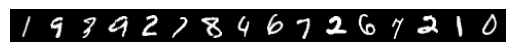

-------------Noisy images-------------


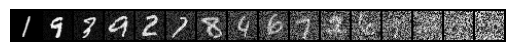

In [6]:
## A bit of check ##

## Getting a batch of images ##
for image_batch, _ in dl:
    break

## Getting the batch size ##
batch_size = image_batch.shape[0]

## Setting the amount ##
## We will use linspace to create (steps) equally spaced values ##
## between start and end. (steps) is the parameter in torch.linspace ##
## which indicates how many values we need. ##
amount = torch.linspace(start=0., end=1., steps=batch_size)

## We have the image_batch and the amount ##
## Lets get our noisy image batch ##
noisy_image_batch = forward_process(image_batch, amount)

## Lets visualize the original and the noisy images ##

print(f'-------------Original images-------------')

visualize_image_batch(image_batch, nrow=batch_size)

print(f'-------------Noisy images-------------')
visualize_image_batch(noisy_image_batch, nrow=batch_size)

I hope this image makes everything clear for the forward process. 

Now we can move to the reverse process.

#### Step 2b : Reverse Process

The thing is even though the reverse process seems to be very similar to the forward process, the reverse process is actually pretty difficult. 

But can't we just use the forward process weighted sum formula to get back the image because it was really easy? Well the answer is no we cannot use that. The reason being that for the previous formula to work we must know the original data to get back the denoised image. But funny enough during reverse process since we start from a random noise how can we be sure what is the original data? Think about the digit images just above this cell. All the digits' can be noisified to a random noise, but from the random noise can you know what is the original data? Well no because to know that, you need to know all the data that the world possesses of digits and their look when they have are fully noisified. This is quite improbable.

So, what to do? Well that's why we use our very dear Neural Network to try to capture the original data from the noise. We can then optimize our dear neural network by doing a MSE loss between the denoised image generated by our neural network and the original image, right?

This is what the reverse process does concisely and we are going to implement it now. 

In [7]:
## Implementing the reverse process ##

def reverse_process(network : nn.Module, noisy_images : torch.tensor):
    """Implements the reverse process and generates denoised image
    by putting the noisy_images inside the network.
    
    Parameters
    ----------
    network : nn.Module
        The neural network which predicts the denoised image.
        
    noisy_images : torch.tensor
        The noisy_images from which denoising is done.
    """
    
    ## Put the noisy images in the network ##
    denoised_images = network(noisy_images)
    
    return denoised_images

Perfect. But what is this network. Well typically it is an [UNET](https://arxiv.org/pdf/1505.04597.pdf) with many advancements. But in this notebook we are going to implement the very simple unet with 2 downsample layers and 2 upsample layers. We will use the `SiLU()` non-linearity. Also we do a small tweak to our `UNET` from the original model. Instead of concatenating the skip connection we add them. Aprat from that everything is same. 

As you can understand it is very basic and we are going to implement it next. Our simple unet can be visualized as below.

![](unet.png)

With the structure in mind let's build our network.

In [8]:
## Defining our network ##

class SimpleUnet(nn.Module):
    """Implements the simple unet."""
    
    def __init__(self):
        """Defines the constructor."""
        
        super().__init__()
        
        ## Setting just the convolutional layers of the downsample blocks ##
        self.down_conv_blocks = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
        ])
        
        ## Setting just the convolutional layers of the bridge block ##
        self.bridge_conv_blocks = nn.ModuleList([
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
        ])
        
        ## Setting just the convolutional layers of the upsample blocks ##
        self.up_conv_blocks = nn.ModuleList([
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
        ])
        
        ## Setting the final convolutional layer ##
        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
        )
        
        ## Setting the silu activation ##
        self.activation = nn.SiLU()
        
        ## Setting the downsample layer ##
        self.down_sample_layer = nn.MaxPool2d(2, 2)
        
        ## Setting the upsampling layer ##
        self.up_sample_layer = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        """Generic Forward pass.
        
        Parameters
        ----------
        x : torch.tensor
            A batch of noisy images.
        """
        
        ## Container for saving the intermediate outputs for skip connections ##
        intermediate_outputs = []
        
        ## Passing through the downsample block ##
        for layer in self.down_conv_blocks:
            ## Passing through conv + act layers ##
            x = self.activation(layer(x))
            
            ## Saving the intermediate outputs for use in up blocks ##
            intermediate_outputs.append(x)
            
            ## Downsampling ##
            x = self.down_sample_layer(x)
            
        ## Passing through the bridge block ##
        for layer in self.bridge_conv_blocks:
            ## Passing through conv + act layers ##
            x = self.activation(layer(x))
            
        ## Passing through the upsampling block ##
        for layer in self.up_conv_blocks:
            ## First doing upsampling ##
            x = self.up_sample_layer(x)
            
            ## Getting the corresponding activation from the down blocks ##
            intermediate = intermediate_outputs.pop()
            
            ## Concatenating the intermediate activation in channel dims ##
            x = x + intermediate
            
            ## Passing through conv layer + silu layer ##
            x = self.activation(layer(x))
            
        ## Finally passing through the final output layer ##
        x = self.final_layer(x)
        
        return x

Perfect, now we have our network too. So, what's next? 

Well to be honest there is nothing else to do but train the network. 

So lets do that.

#### Step 3 : Training the model

In this step we are going to use our very simple unet and train it predict denoised image. Typically as we move further you will see other types of optimization objective but in this simple framework we are going to optimize our network based on the mse loss between the predicted denoised image by our unet and the original data. So, without further adieu lets do this.

In [9]:
## Defining the training setup ##

def train(num_epochs : int):
    """Training scheme.
    
    Parameters
    ----------
    num_epochs : int
        Number of epochs to train the network.
    """
    
    ## Setting the device ##
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    ## Initializing our model ##
    net = SimpleUnet().to(device)
    
    ## Setting our optimizer ##
    optim = torch.optim.Adam(net.parameters(), lr=3e-4)
    
    ## Train, train, train ... ##
    for i in range(num_epochs):
        loop = tqdm(dl)
        
        for imgs, _ in loop:
            
            optim.zero_grad()
            
            ## Setting the correct device for images ##
            imgs = imgs.to(device)
            
            ## Create random amounts between (0,1) ##
            amounts = torch.rand(size=(imgs.shape[0],)).to(device)
            
            ## Create noisy images ##
            noisy_image_batch = forward_process(images=imgs, amount=amounts)
            
            ## Getting denoised image via the network ##
            pred_denoised_imgs = reverse_process(network=net, noisy_images=noisy_image_batch)
            
            ## Getting loss ##
            loss = F.mse_loss(pred_denoised_imgs, imgs)
            
            ## Optimizing ##
            loss.backward()
            optim.step()
            
            ## Some print statements for the progress bar ##
            loop.set_description(f'Epochs : {i + 1} / {num_epochs}')
            loop.set_postfix(loss = loss.item())
            
    torch.save(net.state_dict(), 'net.pt')
            
## Finally setting the training ##
## I am going to train for 10 epochs ##

train(20)

  0%|          | 0/3750 [00:00<?, ?it/s]

Epochs : 20 / 20: 100%|██████████| 3750/3750 [00:38<00:00, 96.51it/s, loss=0.00704] 


Perfect. We have a trained model. Now let's test and see how our model predicts.

#### Step 4 : Checking predictions

We will see how our model's prediction works by using the test set of MNIST.

-------------Original images-------------


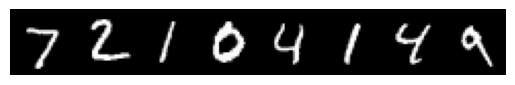

-------------Noisy images-------------


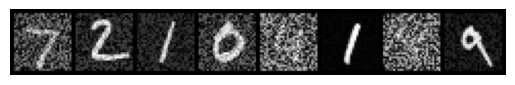

-------------Denoised images-------------


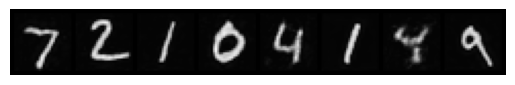

In [10]:
## Setting the device ##
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Loading the test set of mnist ##
test_dataset = MNIST(root='data', train=False, download=True, transform=augmentation)

## Wrapping into dataloader ##
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Loading the network ##
net = SimpleUnet().to(device)
net.load_state_dict(torch.load('net.pt', map_location=device))
net.eval()

## Doing a prediction ##

for imgs, _ in test_dl:
    
    imgs = imgs.to(device)
    
    amount = torch.rand(size=(imgs.shape[0],)).to(device)
    
    noisy_imgs = forward_process(imgs, amount)
    
    with torch.no_grad():
        denoised_imgs = reverse_process(net, noisy_imgs)
    
    print(f'-------------Original images-------------')
    visualize_image_batch(imgs, nrow=8)
    
    print(f'-------------Noisy images-------------')
    visualize_image_batch(noisy_imgs, nrow=8)
    
    print(f'-------------Denoised images-------------')
    visualize_image_batch(denoised_imgs, nrow=8)
    
    break

Hmm, one strange aspect is that the images do look a bit blurry when the noise level is high. Let's see that more in indepth. Let's just askour network to generate images from pure noise and see if this is truly the case.

-------------Noise images-------------


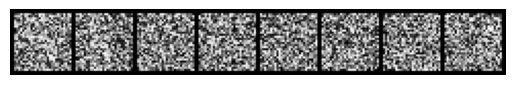

-------------Denoised images-------------


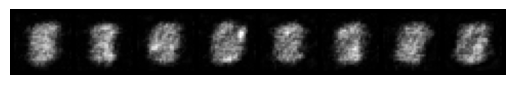

In [11]:
## Checking from pure noise ##

## Setting the random seed such that same thing will be generated ##
## Useful for comparison ##

torch.manual_seed(97)
torch.cuda.manual_seed(97)

## Making the noise the same shape as the imgs the model expect ##

noise_batch = torch.rand(8, 1, 28, 28).to(device) # mnist is 28x28

with torch.no_grad():
    denoised_imgs = reverse_process(net, noise_batch)


print(f'-------------Noise images-------------')
visualize_image_batch(noise_batch, nrow=8)

print(f'-------------Denoised images-------------')
visualize_image_batch(denoised_imgs, nrow=8)

Yes, the results from pure noise is pretty bad. Is there any way to make this better? The answer is yes. But before we move on to that, this process of generation of samples from noise is called **Sampling** and has been a topic of research in Diffusion Models.

So, let's discuss our better sampling process.

#### Step 4 but better : Sampling

In the previous step we were doing sampling directly from noise. Over the years of research in diffusion models shows that nay, that is not good. Instead it seems to be better if we do this denoising step by step. What I mean is just like the way we added noise via a weighted function we could also denoise in that order. We can generate a denoised image at a certain point from the noise, and then use that image to generate an image which is lesser in noise. In this way, we go on and after a certain time we would see a much better result. So, lets do this.

-------------Noise images-------------


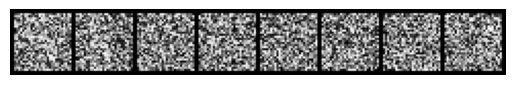

-------------Denoised images-------------


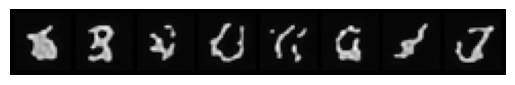

In [12]:
## A better sampling ##

def sample(net : nn.Module, noise : torch.tensor, steps : int = 1000):
    """Derives sample from the learned model.
    
    Parameters
    ---------
    net : nn.Module
        The trained denoising network.
    
    noise : torch.tensor
        The noise from which sample is
        generated.
        
    steps : int
        Number of intermediate steps to do
        from noise to data.
        [Default : 10]
    """
    
    x = noise.clone()
    
    for i in range(steps):
        
        with torch.no_grad():
            denoised_imgs = reverse_process(net, x)
            
        mix_amount = 1 / (steps - i) 
        x = mix_amount * denoised_imgs + (1 - mix_amount) * x
    
    return x

## Testing the improved sampling ##

denoised_imgs = sample(net, noise_batch)

print(f'-------------Noise images-------------')
visualize_image_batch(noise_batch, nrow=8)

print(f'-------------Denoised images-------------')
visualize_image_batch(denoised_imgs, nrow=8)

These look way better than the previously generated images. There you have it. Your simple diffusion model. 

We will do so much more with this understanding in sight. Let me know if there were any issues and improvements in this notebook you want.